# MidiNet2デモ

- サンプルの生成
- サンプルのオーディオ化
- サンプルの可視化，読込，再生

In [1]:
import os, ipdb, pickle, numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import pretty_midi
from pypianoroll import Multitrack, Track
from utils import grid_plot, Timer, ppr_to_audio, get_model, on_chord_rate

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
base_dir = "../datasets/theorytab/midinet"
learning_dir = f"{base_dir}/learning"

## サンプルの生成に必要なコード
主に
- SampleGenerator: Generatorからbatch_normを抜いたもの
- SongGenerator: SampleGeneratorを使って最初の小節，コード進行，セクション情報から曲(Multitrack)を作成

In [3]:
def concat_vector(x, y):
    x_0, _, x_2, x_3 = x.shape
    y2 = y.expand(x_0, y.shape[1], x_2, x_3)
    return torch.cat((x, y2),1)

def lrelu(x, leak=0.2):
    z = torch.mul(x,leak)
    return torch.max(x, z)

class SelfAttention(nn.Module):
    """ Self Attention Layer """
    
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        
        # Self Attention の学習に使用する層を定義
        
        # pointwise convolutionによる特徴量変換，圧縮
        # Attention Mapに使われるxは3つあり，それぞれに対して適用
        # これが非常に大きなカーネルを設定するよりも高速になるらしい
        self.query_conv = nn.Conv2d(in_dim, in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_dim, in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_dim, in_dim,kernel_size=1)
        
        # Attention Map 作成時の規格化用Softmax
        self.softmax = nn.Softmax(dim=-2)
        
        # Attention Mapにかける係数
        self.gamma = nn.Parameter(torch.zeros(1))
        
        
    def forward(self, x, get_map=False):
        
        # (B, C', W, H) -> (B, C', N)
        proj_query = self.query_conv(x).view(x.shape[0], -1, x.shape[2]*x.shape[3])
        
        # 転置 x^t
        proj_query = proj_query.permute(0, 2, 1)
        
        # 転置してない方の x
        proj_key = self.key_conv(x).view(x.shape[0], -1, x.shape[2] * x.shape[3]) # (B, C', N)
        
        # バッチごとに行列の掛け算 x^t x を行う
        S = torch.bmm(proj_query, proj_key)
        
        # 規格化と転置を行い，Attention Mapを作成
        attention_map_T = self.softmax(S)
        attention_map = attention_map_T.permute(0, 2, 1)
        
        # xに対応する調整量 o を取得
        proj_value = self.value_conv(x).view(x.shape[0], -1, x.shape[2]*x.shape[3]) # (B, C', N)
        o = torch.bmm(proj_value, attention_map.permute(0, 2, 1))
        
        # x + gamma o　を返す
        o = o.view(x.shape[0], x.shape[1], x.shape[2], x.shape[3])
        out = x + self.gamma * o
        
        if get_map:
            return out, attention_map
        else:
            return out

class SampleGenerator(nn.Module):
    def __init__(self, z_dim=100, pitch_range=64):
        super(SampleGenerator, self).__init__()
        self.nz      = z_dim
        self.y_dim   = 48
        
        self.prev_ch = 16
        self.gf_dim  = 128
        self.gfc_dim = 1024

        self.h1      = nn.ConvTranspose2d(self.gf_dim+self.y_dim+self.prev_ch, pitch_range, kernel_size=(2,1), stride=(2,1))
        self.h2      = nn.ConvTranspose2d(pitch_range+self.y_dim+self.prev_ch, pitch_range, kernel_size=(3,1), stride=(3,1))
        self.h3      = nn.ConvTranspose2d(pitch_range+self.y_dim+self.prev_ch, pitch_range, kernel_size=(2,1), stride=(2,1))
        self.h4      = nn.ConvTranspose2d(pitch_range+self.y_dim+self.prev_ch, pitch_range, kernel_size=(2,1), stride=(2,1))
        self.h5      = nn.ConvTranspose2d(pitch_range+self.y_dim+self.prev_ch, 1, kernel_size=(1,pitch_range), stride=(1,1))

        self.h0_prev = nn.Conv2d(1, self.prev_ch, kernel_size=(1,pitch_range), stride=(1,1))
        self.h1_prev = nn.Conv2d(self.prev_ch, self.prev_ch, kernel_size=(2,1), stride=(2,1))
        self.h2_prev = nn.Conv2d(self.prev_ch, self.prev_ch, kernel_size=(2,1), stride=(2,1))
        self.h3_prev = nn.Conv2d(self.prev_ch, self.prev_ch, kernel_size=(3,1), stride=(3,1))
        self.h4_prev = nn.Conv2d(self.prev_ch, self.prev_ch, kernel_size=(2,1), stride=(2,1))
        
        self.sa1 = SelfAttention(self.gf_dim+self.y_dim+self.prev_ch)
        self.sa2 = SelfAttention(pitch_range+self.y_dim+self.prev_ch)
        self.sa3 = SelfAttention(pitch_range+self.y_dim+self.prev_ch)
        self.sa4 = SelfAttention(pitch_range+self.y_dim+self.prev_ch)
        self.sa5 = SelfAttention(pitch_range+self.y_dim+self.prev_ch)
        
        self.linear1 = nn.Linear(self.nz + self.y_dim, self.gfc_dim)
        self.linear2 = nn.Linear(self.gfc_dim + self.y_dim, self.gf_dim*2*1)

    def forward(self, z, prev_x, y):
        
        batch_size = len(z)
        
        h0_prev = lrelu(self.h0_prev(prev_x))   # 72, 16, 48, 1 ピッチ方向の畳み込み
        h1_prev = lrelu(self.h1_prev(h0_prev))  # 72, 16, 24, 1
        h2_prev = lrelu(self.h2_prev(h1_prev))  # 72, 16, 12, 1
        h3_prev = lrelu(self.h3_prev(h2_prev))  # 72, 16, 4, 1
        h4_prev = lrelu(self.h4_prev(h3_prev))  # 72, 16, 2, 1

        yb = y.view(batch_size, self.y_dim, 1, 1)           # 72, 48, 1, 1

        z = torch.cat((z,y),1)                              # 72, 148

        h0 = F.relu(self.linear1(z))            # 72, 1024
        h0 = torch.cat((h0,y),1)                            # 72, 1072

        h1 = F.relu(self.linear2(h0))           # 72, 256
        h1 = h1.view(batch_size, self.gf_dim, 2, 1)         # 72, 128, 2, 1
        h1 = concat_vector(h1, yb)                          # 72, 176, 2, 1
        h1 = concat_vector(h1, h4_prev)                     # 72, 192, 2, 1
        # h1 = self.sa1(h1)

        h2 = F.relu(self.h1(h1))                # 72,  64, 4, 1 逆畳み込み． チャンネル数は固定で，3次元目が拡大される
        h2 = concat_vector(h2, yb)                          # 72, 112, 4, 1
        h2 = concat_vector(h2, h3_prev)                     # 72, 128, 4, 1
        # h2 = self.sa2(h2)

        h3 = F.relu(self.h2(h2))                # 72,  64, 12, 1 
        h3 = concat_vector(h3, yb)                          # 72, 112, 12, 1
        h3 = concat_vector(h3, h2_prev)                     # 72, 128, 12, 1
        h3 = self.sa3(h3)

        h4 = F.relu(self.h3(h3))                # 72,  64, 24, 1
        h4 = concat_vector(h4, yb)                          # 72, 112, 24, 1
        h4 = concat_vector(h4, h1_prev)                     # 72, 128, 24, 1
        h4 = self.sa4(h4)
        
        h5 = F.relu(self.h4(h4))                # 72,  64, 48, 1
        h5 = concat_vector(h5, yb)                          # 72, 112, 48, 1
        h5 = concat_vector(h5, h0_prev)                     # 72, 128, 48, 1
        # h4 = self.sa5(h5)
        
        g_x = torch.sigmoid(self.h5(h5))                    # 72, 1, 48, 64  ピッチ方向の逆畳み込み

        return g_x

In [4]:
_eye = np.eye(6)
section_vector_dict = {
    'intro'        : _eye[0],
    'verse'        : _eye[1],
    'bridge'       : _eye[2],
    'chorus'       : _eye[3],
    'instrumental' : _eye[4],
    'outro'        : _eye[5],
}

chord_key_dict = {
    'C'  : 0,
    'C#' : 1,
    'Db' : 1,
    'D'  : 2,
    'D#' : 3,
    'Eb' : 3,
    'E'  : 4,
    'F'  : 5,
    'F#' : 6,
    'Gb' : 6,
    'G'  : 7,
    'Ab' : 8,
    'A'  : 9,
    'A#' : 10,
    'Bb' : 10,
    'B'  : 11,
}

chord_kind_dict = {
    ''     : [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
    '5'    : [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    'm'    : [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
    '7'    : [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
    'M7'   : [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1],
    'm7'   : [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
    'mM7'  : [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1],
    'sus4' : [1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
    '7sus4': [1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0],
    'dim'  : [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
    'm7-5' : [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0],
    'aug'  : [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
    'add9' : [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0],
    '6'    : [1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0],
    'm6'   : [1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0],
}

def get_chord_vector(chord_name, octave_range=1):
    chord_vector = [0] * 12 * octave_range
    if '#' in chord_name or 'b' in chord_name:
        key, kind = chord_name[:2], chord_name[2:]
    elif chord_name:
        key, kind = chord_name[:1], chord_name[1:]
    else:
        return chord_vector
    key, chord_vector[:12] = chord_key_dict[key], chord_kind_dict[kind]
    chord_vector = chord_vector[-key:] + chord_vector[:-key]
    return chord_vector
    

class SongIsNotGeneratedError(Exception):
    pass

class SongGenerator():
    def __init__(self, model):
        if not isinstance(model, SampleGenerator):
            raise ValueError("model type should be SampleGenerator.")
        
        self.model = model
        self.song_map = None

        self.beat_res = 12
        self.beats_in_bar = 4
        self.bar_res = self.beat_res * self.beats_in_bar

        self.pitch_range = [36, 99]
        self.on_note_thresh = 0
        self.melody_is_monophonic = True
        self.fill_interval = None
        self.shortest_note_steps = None
        self.transpose = 0
    
    def make_vectors_from_chord_list(self, chord_list):
        # 拍ごとにコードベクトルへ変換
        chord_vectors = []
        for chord, beats in chord_list:
            chord_vector = get_chord_vector(chord)
            for b in range(beats):
                chord_vectors.append(chord_vector)
        
        # 最後の小節に空白があるならNo Chordで埋める
        overhang_beat_num = len(chord_vectors) % self.beats_in_bar
        if overhang_beat_num > 0:
            filling = get_chord_vector('')
            for i in range(self.beats_in_bar - overhang_beat_num):
                chord_vectors.append(filling)
        
        # 小節ごとのコードベクトルへ変換
        chord_vectors = np.array(chord_vectors)
        bar_num = len(chord_vectors) // self.beats_in_bar
        vector_len = 12 * self.beats_in_bar
        chord_vectors = chord_vectors.reshape(bar_num, vector_len)
        
        return chord_vectors
                
    def make_vectors_from_section_list(self, section_list):
        section_vectors = []
        
        for section, bars in section_list:
            section_vector = section_vector_dict[section]
            for bar in range(bars):
                section_vectors.append(section_vector)
        
        section_vectors = np.array(section_vectors)
        
        return section_vectors
    
    def make_vectors_from_condition_lists(self, chord_list, section_list):
        chord_vectors = self.make_vectors_from_chord_list(chord_list)
        section_vectors = self.make_vectors_from_section_list(section_list)
        
        if len(chord_vectors) != len(section_vectors):
            raise ValueError("Lengths of chord part and section are different.")
        
         #condition_vectors = np.concatenate([chord_vectors, section_vectors], axis=1)
        condition_vectors = chord_vectors
        
        return condition_vectors

    def make_pianoroll_from_chord_list(self, chord_list, octave=3):
        chord_vectors = []
        empty_vector = [0] * 12 * 2
        
        for chord, beats in chord_list:
            chord_vector = get_chord_vector(chord, octave_range=2)
            
            # コードの終端ステップは空にする
            for step in range(beats * self.beat_res - 1):
                chord_vectors.append(chord_vector)
            chord_vectors.append(empty_vector)
        
        # 最後の小節に空白があるならNo Chordで埋める
        overhang_step_num = len(chord_vectors) % (self.bar_res)
        if overhang_step_num > 0:
            for step in range(self.bar_res - overhang_step_num):
                chord_vectors.append(empty_vector)
        
        pianoroll = np.zeros([len(chord_vectors), 128])
        bottom, top = (octave+1) * 12, (octave + 3) * 12
        pianoroll[:, bottom:top] = chord_vectors
        
        return pianoroll

    def make_pianoroll_from_note_list(self, note_list):
        eye = np.eye(128)
        empty_vector = [0] * 128
        note_vectors = []
        
        for pitch, div in note_list:
            note_length = int(self.bar_res // div)
            
            if pitch is not None:
                note_vector = eye[pitch]
            else:
                note_vector = empty_vector
            
            if note_length > 1:
                # 長さが1ステップ分より長ければ，終端を空白にする
                for l in range(note_length - 1):
                    note_vectors.append(note_vector)
                note_vectors.append(empty_vector)
            else:
                note_vectors.append(note_vector)
        
        # 最後の小節に空白があるなら空白で埋める
        overhang_step_num = len(note_vectors) % (self.bar_res)
        if overhang_step_num > 0:
            for step in range(self.bar_res - overhang_step_num):
                note_vectors.append(empty_vector)
        
        pianoroll = np.array(note_vectors)
        
        return pianoroll
    
    def make_generated_bars_list_by_empty_bars(self, melody):
        empty_bars = []
        
        for bar in range(bars_num):
            left, right = bar*bar_res, (bar+1)*bar_res
            if not np.any(np.any(melody[left:right], axis=-1), axis=-1):
                empty_bars.append(bar)

        generated_bars_list = empty_bars
        
        return generated_bars_list
        
    def generate_melody(self, base_pianoroll, condition_vectors, generated_bars_list=None):
        bar_res = self.bar_res
        bottom, top = self.pitch_range
        bars_num = len(condition_vectors)
        
        # 必要小節分のノイズベクトルを一度に生成
        noise_vectors = torch.randn(bars_num, self.model.nz)
        
        # 必要小節分の空データを用意し，base melodyを仕込む.
        # base_melodyのcondition_vectorsの長さを超える部分はカット
        melody = torch.zeros([bar_res * bars_num, 128])
        base_melody = torch.from_numpy(base_pianoroll[:bars_num*bar_res].astype(np.float32))
        melody[:len(base_melody)] = base_melody
        
        condition_vectors = torch.from_numpy(condition_vectors.astype(np.float32))
        
        # 生成する小節の範囲が与えられていなければ，全ての空白の小節でメロディを作成する
        if generated_bars_list is None:
            generated_bars_list = self.make_generated_bars_list_by_empty_bars(melody)
        
        # 指定小節のメロディを各個生成
        for bar in generated_bars_list:
            noise_vector = noise_vectors[bar].view(1, -1)
            
            if bar == 0:
                # 最初の小節が無ければ空の小節を使用
                prev = torch.zeros([1, 1, bar_res, 128])
            else:
                # 最初でなければ前の小節を使用
                left, right = (bar-1) * bar_res, bar * bar_res
                prev = melody[left:right, bottom:top+1].view(1, 1, bar_res, 64)
            
            condition_vector = condition_vectors[bar].view(1, -1)
            
            generated_bar = self.model(noise_vector, prev, condition_vector)
            
            left, right = bar * bar_res, (bar+1) * bar_res
            melody[left:right, bottom:top+1] = generated_bar[0][0]
        
        melody = melody.detach().numpy()
        
        # 生成されたデータを直接見るため，song_mapとして保持
        self.song_map = melody.copy()
            
        return melody
    
    def monophonize(self, pianoroll):
        max_pitches = np.argmax(pianoroll, axis=1)
        empty_steps = np.where(np.any(pianoroll, axis=1) == False)[0]

        monophonic = np.zeros_like(pianoroll)
        monophonic[range(len(max_pitches)), max_pitches] = 1
        monophonic[empty_steps] = 0
                        
        return monophonic
    
    def fill(self, pianoroll):
        fill_int = self.fill_interval
        filled_len = len(pianoroll) // fill_int
        
        for filled_step in range(filled_len):
            left, right = filled_step * fill_int, (filled_step+1) * fill_int
            
            # filled_step区間内に存在するピッチ中，最頻のもので埋める
            steps, pitches = np.where(pianoroll[left:right])
            is_end_of_note = not np.any(pianoroll[right-1])
            if pitches.any():
                representative = np.argmax(np.bincount(pitches))
                pianoroll[steps+left, pitches] = 0
                pianoroll[left:right, representative] = 1
                
                # ステップの終端が空白なら音符の切れ目と判定してそこだけ切る
                if is_end_of_note:
                    pianoroll[right-1] = 0
                
        return pianoroll
    
    def remove_short_notes(self, melody):
        thresh = self.shortest_note_steps
        note_existence = np.any(melody, axis=1)
        
        last_pitches = None
        same_pitch_steps = 0
        for step, pitches in enumerate(melody):
            
            # 今のステップに音符があるなら，
            if note_existence[step]:
                # そこが音符の開始地点の時，新たな音符を開始
                if last_pitches is None:
                    last_pitches = pitches # 開始地点として保持し，
                    same_pitch_steps += 1  # 長さのカウントを開始
                # 前のステップから連続して同じ音符があるとき
                else:
                    # 同じ音程なら，その音符の長さのカウントアップ
                    if np.all(pitches == last_pitches):
                        same_pitch_steps += 1
                    # 異なる音程なら
                    else:
                        # その音符の長さが短い時には音符を削除し，
                        if same_pitch_steps < thresh:
                            melody[step - same_pitch_steps:step] = 0
                        # 新たな音符を開始
                        last_pitches = pitches
                        same_pitch_steps = 1
            
            # 今のステップが空白なら
            else:
                # ここまで空白が連続していないとき，
                if same_pitch_steps > 0:
                    # 前の音符が短い時にはその音符を削除
                    if same_pitch_steps < thresh:
                        melody[step - same_pitch_steps:step] = 0
                    # 空白を開始
                    last_pitches = None
                    same_pitch_steps = 0
        
        # 最後に短い音符があるとき，削除
        if same_pitch_steps == 1:
            melody[-1] = 0
        
        return melody
    
    def post_process_melody(self, melody):
        # 出力値が小さいところは休符の可能性が高いので消去
        melody[melody < self.on_note_thresh] = 0
        
        # 1ステップに1つの音が鳴るようにステップごとの最大値を取る
        if self.melody_is_monophonic:
            melody = self.monophonize(melody)
        
        if self.shortest_note_steps is not None:
            melody = self.remove_short_notes(melody)
        
        # 細かい音符を消し去るため，長さfill_resの区間ごとに使用率の最も高い音符で埋める
        if self.fill_interval is not None:
            melody = self.fill(melody)
        
        return melody

    def make_song(self, tracks, track_names, name=None):
        tracks = [Track(item, name=name) for item, name in zip(tracks, track_names)]
        
        downbeat = np.zeros(len(tracks[0].pianoroll), dtype=bool)
        downbeat[::self.bar_res] = True
        
        song = Multitrack(tracks=tracks, beat_resolution=self.beat_res, downbeat=downbeat)
        
        song.binarize()
        
        if self.transpose is not None:
            for track in song.tracks:
                track.transpose(self.transpose)
                
        if name is not None:
            song.name = name
        
        return song

    def generate(self, base_note_list, chord_list, section_list, generated_bars_list=None, name=None):
        base_pianoroll    = self.make_pianoroll_from_note_list(base_note_list)
        condition_vectors = self.make_vectors_from_condition_lists(chord_list, section_list)
        melody_pianoroll  = self.generate_melody(base_pianoroll, condition_vectors, generated_bars_list)
        melody_pianoroll  = self.post_process_melody(melody_pianoroll)
        chord_pianoroll   = self.make_pianoroll_from_chord_list(chord_list)
        song              = self.make_song([melody_pianoroll, chord_pianoroll], ['melody', 'chord'], name)
        return song

    def show_map(self, figsize=(21, 7)):
        if self.song_map is None:
            raise SongIsNotGeneratedError("Generate song before show the result map of the generator.")
        bottom, top = self.pitch_range
        fig, ax = plt.subplots(figsize=figsize)
        return ax.imshow(np.flipud(self.song_map[:, bottom:top+1].T))

## 楽譜の生成
ここでRun All Aboveして以下で曲を作成する  
1. modelを選ぶ
2. sections, chords, primingを作る
3. SongGenerator(model).generate()で自動生成されたMultitrackオブジェクトを取得
4. 気に入ったらオーディオとして保存
5. また聞きたくなったらget_sample(search_dir)でAudioオブジェクトとMultitrackオブジェクトを得られる

In [18]:
version = "midinet_sa"
model = get_model(os.path.join(learning_dir, version), SampleGenerator, prefix="G_epoch")
song_generator = SongGenerator(model)

5 models found in ../datasets/theorytab/midinet/learning/midinet_sa
0: G_epoch=0100_z=512.pth
1: G_epoch=0200_z=512.pth
2: G_epoch=0300_z=512.pth
3: G_epoch=0400_z=512.pth
4: G_epoch=0500_z=512.pth
input the number of model:4
model is loaded from G_epoch=0500_z=512.pth


on chord rate 0.42184154175588867


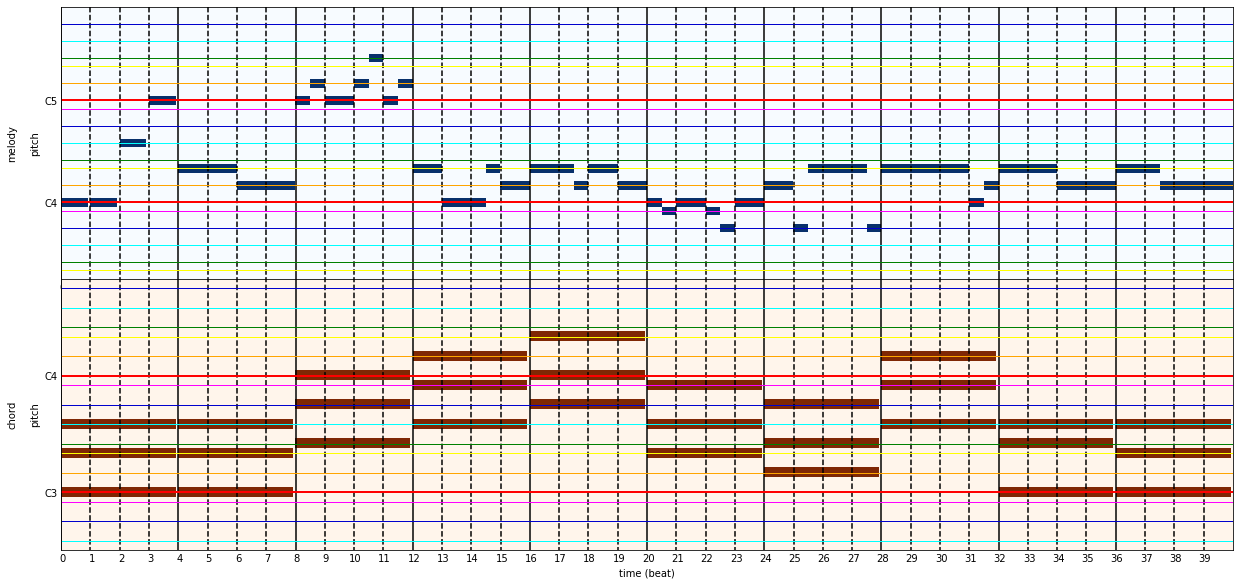

In [21]:
song_name = "sample000_C"

# セクションの流れ，長さの単位は小節数．全体の長さはこの長さに合わせられる
section_lineup = ['intro', 'verse', 'bridge', 'chorus', 'instrumental', 'outro']
# sections = [("intro", 2), ('chorus', 2), ('instrumental', 4), ('outro', 2)]
sections = [("chorus", 8), ('outro', 2)]

# コード進行，長さの単位は拍数
chords = [("C", 4), ("C", 4), ("F", 4), ("G", 4), ("Am", 4), ("Em", 4), ("Dm", 4), ("G", 4), ("Csus4", 4), ("C", 4)]
# chords = [("Am", 4), ("Em", 4), ("F", 4), ("C", 2), ("G", 2), ("Am", 4), ("Em", 4), ("F", 4), ("Gsus4", 4), ("E", 4), ("Am", 4)]

# ベースとなるメロディ，長さの単位は何分音符か．音符の終端は12分音符分カットされる
base = [(60, 4), (60, 4), (67, 4), (72, 4), (None, 1/8), (72, 1)]
# base = [(57, 4), (57, 4), (60, 4), (64, 4), (None, 1/8), (69, 1)]

# 自動生成する小節の範囲
generated = list(range(1,10))

song_generator.fill_interval = 6
song = song_generator.generate(base, chords, sections, generated_bars_list=generated, name=song_name)
print("on chord rate", on_chord_rate(song))
grid_plot(song)

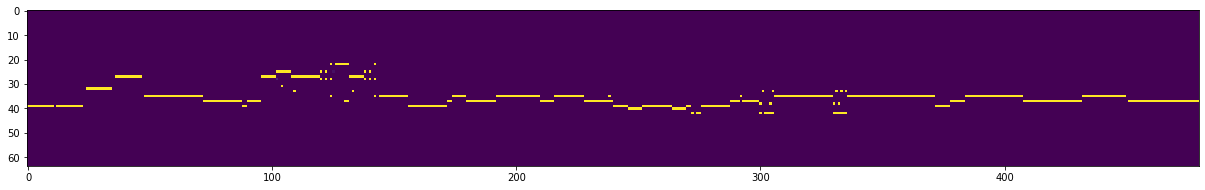

In [22]:
song_generator.show_map()

## サンプルのオーディオ化

In [28]:
tempo = 120
song.tracks[0].program = 90
song.tracks[1].program = 0
song.tracks[0].assign_constant(100)
song.tracks[1].assign_constant(64)

print("melody instrument:", pretty_midi.program_to_instrument_name(song.tracks[0].program))
print("chord  instrument:", pretty_midi.program_to_instrument_name(song.tracks[1].program))
save_dir = os.path.join(learning_dir, version)

ppr_to_audio(song, save_dir)

melody instrument: Pad 3 (polysynth)
chord  instrument: Acoustic Grand Piano
wave file length: 926100
wave file saved to ../datasets/theorytab/midinet/learning/midinet2_dense/sample000_C.wav
sample000_C.midi file saved!
The wave file is replaced to ../datasets/theorytab/midinet/learning/midinet2_dense/sample000_C.mp3 



## 生成音楽の読み込みと可視化，再生

31 sounds found in ../datasets/theorytab/midinet/learning/midinet2_dense
0: sample000_C.mp3
1: sample001_C.mp3
2: sample002_A.mp3
3: sample002_Bb.mp3
4: sample002_C#.mp3
5: sample002_C.mp3
6: sample002_D#.mp3
7: sample002_D.mp3
8: sample002_E.mp3
9: sample002_G.mp3
10: sample003_C.mp3
11: sample004_C.mp3
12: sample005_C.mp3
13: sample006_C.mp3
14: sample007_C.mp3
15: sample008_C.mp3
16: sample009_C.mp3
17: sample010_C.mp3
18: sample011_C.mp3
19: sample013_C.mp3
20: sample014_C.mp3
21: sample015_C.mp3
22: sample016_Am.mp3
23: sample017_Am.mp3
24: sample018_Am.mp3
25: sample019_Am.mp3
26: sample020_Am.mp3
27: sample020_C.mp3
28: sample021_C.mp3
29: sample022_C.mp3
30: sample023_C.mp3


input the number of sound(empty for the last): 8


sound is loaded from ../datasets/theorytab/midinet/learning/midinet2_dense/sample002_E.mp3
midi is loaded from ../datasets/theorytab/midinet/learning/midinet2_dense/sample002_E.midi


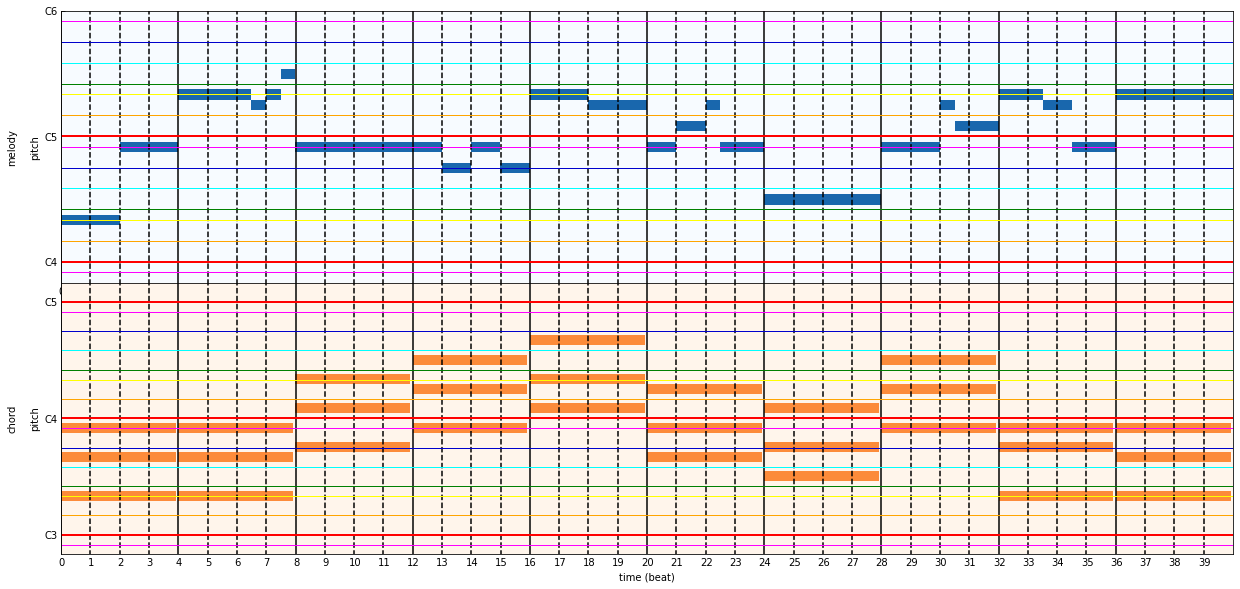

In [24]:
from utils import grid_plot, get_sample
%matplotlib inline

version = "midinet2_dense"
learning_dir = "../datasets/theorytab/midinet/learning"
audio, ppr = get_sample(f"{learning_dir}/{version}")

grid_plot(ppr)
audio

現存の曲をいじったりもできる

In [33]:
ppr.name = "sample002_C#"
for track in ppr.tracks:
    track.transpose(1)
ppr_to_audio(ppr, save_dir)

wave file length: 926100
wave file saved to ../datasets/theorytab/midinet/learning/midinet2_dense/sample002_C#.wav
sample002_C#.midi file saved!
The wave file is replaced to ../datasets/theorytab/midinet/learning/midinet2_dense/sample002_C#.mp3 

